# GAN - MNIST Experiments

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# set up plotting
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set(color_codes=True)

from IPython.display import clear_output

In [3]:
from tqdm import tnrange

In [4]:
# add deep_networks to path
import sys
sys.path.append('..')

In [5]:
import numpy as np
import tensorflow as tf

In [6]:
from deep_networks import data_util

In [7]:
def display_digits(ax, images, title, num_rows=10, num_cols=10):
    height, width = images.shape[1:]
    image = np.zeros((height * num_rows, width * num_cols))
    
    
    for col in range(num_cols):
        for row in range(num_rows):
            image[row*height:(row+1)*height, col*width:(col+1)*height] = images[row + col * num_rows]
    
    ax.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

def plot_digits(images, title, num_rows=10, num_cols=10):
    fig, ax = plt.subplots(1, 1, figsize=(num_cols, num_rows))
    display_digits(ax, images, title, num_rows=num_rows, num_cols=num_cols)
    plt.show(fig)

## Data Distribution

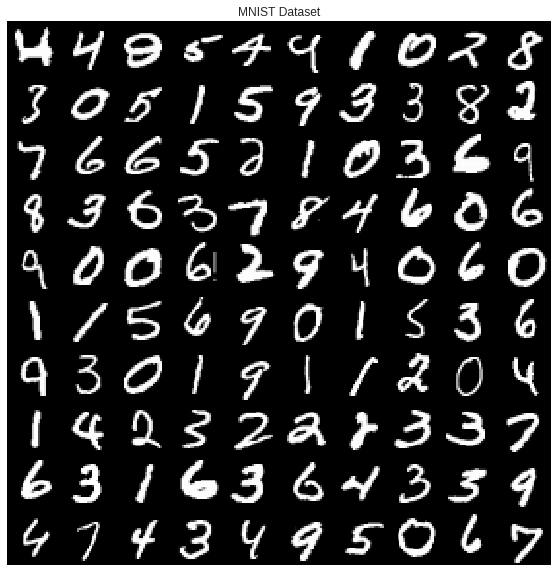

In [8]:
mnist_num_examples = 55000
mnist_batch_size = 64
mnist_num_batches = mnist_num_examples // mnist_batch_size
mnist_image_size = 28
mnist_output_shape = (mnist_image_size, mnist_image_size, 1)
mnist_log_dir = 'logs/MNIST'
mnist_checkpoint_dir = 'checkpoints/MNIST'

def get_mnist_data(shape=mnist_output_shape):
    filename_queue = data_util.list_files_as_filename_queue('mnist.tfrecords')
    image, label = data_util.read_image_from_tfrecords(filename_queue, with_labels=True)
    image.set_shape(shape)
    image = data_util.norm_image(image)
    image = tf.reshape(image, [-1])
    images, labels = tf.train.shuffle_batch([image, label], batch_size=mnist_batch_size,
                                    capacity=2000,
                                    min_after_dequeue=1000)
    return images, labels

def split_mnist_data(images, labels):                                                                                                           
    pred = tf.less(labels, [5])                                                                                                                 
    first_items = tf.reshape(tf.where(pred), [-1])                                                                                              
    first_images = tf.gather(images, first_items)                                                                                               
    first_labels = tf.gather(labels, first_items)                                                                                               
                                                                                                                                                
    first_images, first_labels = tf.train.batch(                                                                                                
        [first_images, first_labels],                                                                                                           
        batch_size=mnist_batch_size,                                                                                                            
        capacity=2000,                                                                                                                          
        enqueue_many=True)                                                                                                                      
                                                                                                                                                
    pred_neg = tf.logical_not(pred)                                                                                                             
    second_items = tf.reshape(tf.where(pred_neg), [-1])                                                                                         
    second_images = tf.gather(images, second_items)                                                                                             
    second_labels = tf.gather(labels, second_items)                                                                                             
                                                                                                                                                
    second_images, second_labels = tf.train.batch(                                                                                              
        [second_images, second_labels],                                                                                                         
        batch_size=mnist_batch_size,                                                                                                            
        capacity=2000,                                                                                                                          
        enqueue_many=True)                                                                                                                      
                                                                                                                                                
    return first_images, first_labels, second_images, second_labels

def denorm(images):
    return data_util.np_denorm_image(images).reshape((-1, mnist_image_size, mnist_image_size))

with tf.Graph().as_default():
    with tf.Session() as sess:
        mnist_data, _ = get_mnist_data()

        tf.global_variables_initializer().run()
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        denorm_data = tf.reshape(data_util.denorm_image(mnist_data), (-1, mnist_image_size, mnist_image_size))
        images = np.vstack([denorm_data.eval(), denorm_data.eval()])
        plot_digits(images, 'MNIST Dataset')

        coord.request_stop()
        coord.join(threads)

In [9]:
mnist_samples = {}

In [10]:
def sample_and_load(model, sample_step, checkpoint_dir, sample_fn):
    resume_step = None
    for step in sample_step:
        success, _ = model.load(checkpoint_dir, step)
        
        if success:
            sample_fn(model, step)
            resume_step = step
        else:
            break
    return resume_step

def sample_GAN(samples, num_batches):
    def sample(gan, step):
        epoch = step // num_batches
        num_samples = 100

        data = denorm(gan.sample(num_samples=num_samples))
        samples.append((epoch, data))

        clear_output()
        plot_digits(data, 'Epoch #{}'.format(epoch))
    
    return sample

def save_and_sample(checkpoint_dir, sample_fn):
    def sample(gan, step):
        gan.save(checkpoint_dir, step)
        sample_fn(gan, step)
    return sample

## Vanilla Generative Adversarial Networks

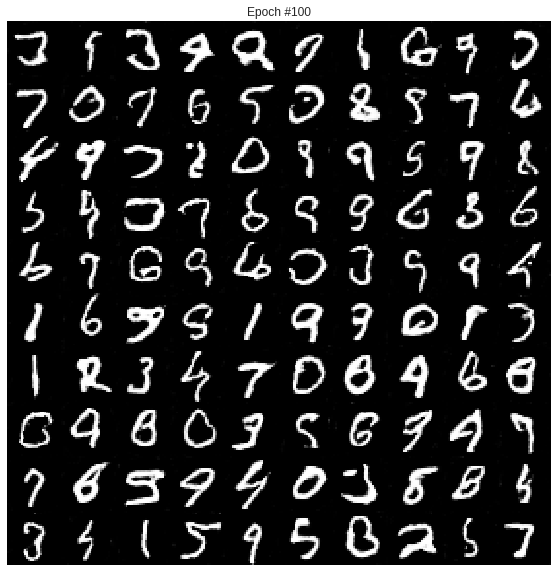

INFO:tensorflow:Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoints/MNIST/GAN/GAN-85900
INFO:tensorflow:Success to read GAN-85900
INFO:tensorflow:checkpoints/MNIST/GAN/GAN-85900 is not in all_model_checkpoint_paths. Manually adding it.


In [11]:
from deep_networks.models.gan import GAN, ConvDiscriminator, ResizeConvGenerator, ConvTransposeGenerator

with tf.Graph().as_default():
    with tf.Session() as sess:
        samples = []
        sample_step = [i * mnist_num_batches for i in (1, 10, 40, 70, 100)]
        data, _ = get_mnist_data()

        gan = GAN(sess,
                  data,
                  num_examples=mnist_num_examples,
                  output_shape=mnist_output_shape,
                  batch_size=mnist_batch_size,
                  generator_cls=ResizeConvGenerator,
                  discriminator_cls=ConvDiscriminator,
                  z_dim=32,
                  g_dim=32,
                  d_dim=32)
        gan._trange = tnrange
        gan.init_saver(tf.train.Saver(max_to_keep=None))
        
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        
        sample_fn = sample_GAN(samples, mnist_num_batches)
        resume_step = sample_and_load(gan, sample_step, mnist_checkpoint_dir, sample_fn)
        gan.train(num_epochs=100,
                  log_dir=mnist_log_dir,
                  checkpoint_dir=mnist_checkpoint_dir,
                  resume_step=resume_step,
                  sample_step=sample_step,
                  save_step=None,
                  sample_fn=save_and_sample(mnist_checkpoint_dir, sample_fn))
        
        coord.request_stop()
        coord.join(threads)
        mnist_samples['GAN'] = samples

## Auxiliary Classifier Generative Adversarial Networks

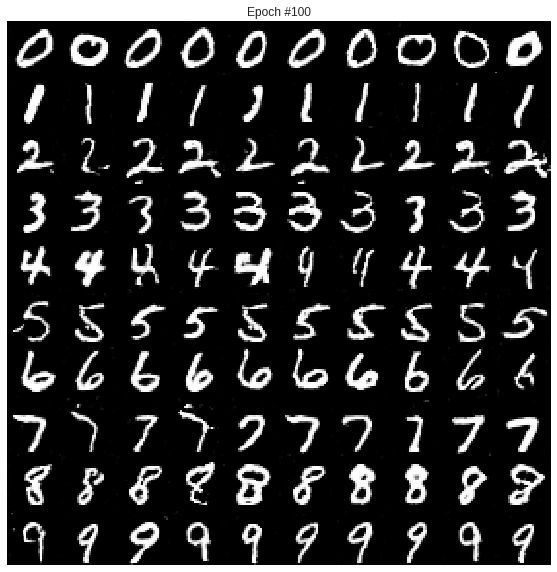

INFO:tensorflow:Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoints/MNIST/ACGAN/ACGAN-85900
INFO:tensorflow:Success to read ACGAN-85900


In [12]:
from deep_networks.models import acgan

def sample_ACGAN(samples, num_batches):
    def sample(gan, step):
        epoch = step // num_batches
        num_samples = 100

        z = gan.sample_z(num_samples)
        c = np.concatenate([np.arange(10) for _ in range(10)])
        data = denorm(gan.sample(z=z, c=c))
        samples.append((epoch, data, c))

        clear_output()
        plot_digits(data, 'Epoch #{}'.format(epoch))

    return sample


with tf.Graph().as_default():
    with tf.Session() as sess:
        samples = []
        sample_step = [i * mnist_num_batches for i in (1, 10, 40, 70, 100)]
        data, labels = get_mnist_data()

        gan = acgan.ACGAN(sess,
                    data,
                    labels,
                    num_examples=mnist_num_examples,
                    num_classes=10,
                    output_shape=mnist_output_shape,
                    batch_size=mnist_batch_size,
                    generator_cls=acgan.ResizeConvGenerator,
                    discriminator_cls=acgan.ConvDiscriminator,
                    z_dim=32,
                    g_dim=32,
                    d_dim=32)
        gan._trange = tnrange
        gan.init_saver(tf.train.Saver(max_to_keep=None))

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        sample_fn = sample_ACGAN(samples, mnist_num_batches)
        resume_step = sample_and_load(gan, sample_step, mnist_checkpoint_dir,
                                      sample_fn)
        gan.train(num_epochs=100,
                  log_dir=mnist_log_dir,
                  checkpoint_dir=mnist_checkpoint_dir,
                  resume_step=resume_step,
                  sample_step=sample_step,
                  save_step=None,
                  sample_fn=save_and_sample(mnist_checkpoint_dir, sample_fn))

        coord.request_stop()
        coord.join(threads)
        mnist_samples['ACGAN'] = samples

## Wasserstein GAN

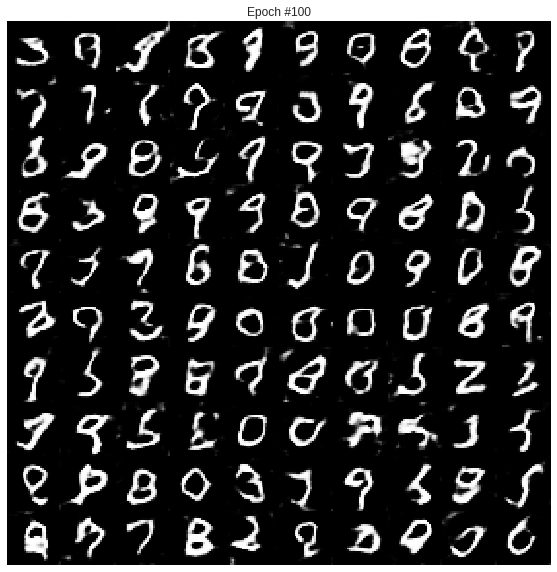

INFO:tensorflow:Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoints/MNIST/WGAN/WGAN-85900
INFO:tensorflow:Success to read WGAN-85900


In [13]:
from deep_networks.models import wgan

with tf.Graph().as_default():
    with tf.Session() as sess:
        samples = []
        sample_step = [i * mnist_num_batches for i in (1, 10, 40, 70, 100)]
        data, _ = get_mnist_data()

        gan = wgan.WGAN(sess,
                  data,
                  num_examples=mnist_num_examples,
                  output_shape=mnist_output_shape,
                  batch_size=mnist_batch_size,
                  generator_cls=ResizeConvGenerator,
                  discriminator_cls=ConvDiscriminator,
                  z_dim=32,
                  g_dim=32,
                  d_dim=32)
        gan._trange = tnrange
        gan.init_saver(tf.train.Saver(max_to_keep=None))

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        sample_fn = sample_GAN(samples, mnist_num_batches)
        resume_step = sample_and_load(gan, sample_step, mnist_checkpoint_dir, sample_fn)

        gan.train(num_epochs=100,
                  log_dir=mnist_log_dir,
                  checkpoint_dir=mnist_checkpoint_dir,
                  resume_step=resume_step,
                  sample_step=sample_step,
                  save_step=None,
                  sample_fn=save_and_sample(mnist_checkpoint_dir, sample_fn))
        
        coord.request_stop()
        coord.join(threads)
        mnist_samples['WGAN'] = samples

## Improved Wasserstein GAN

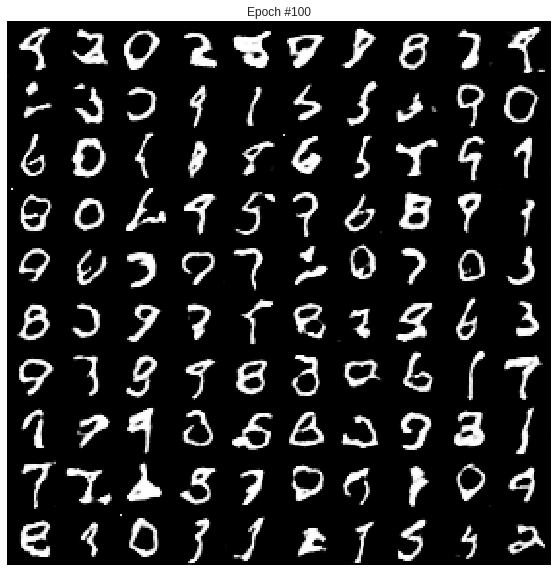

INFO:tensorflow:Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoints/MNIST/iWGAN/iWGAN-85900
INFO:tensorflow:Success to read iWGAN-85900


In [14]:
from deep_networks.models import iwgan

with tf.Graph().as_default():
    with tf.Session() as sess:
        samples = []
        sample_step = [i * mnist_num_batches for i in (1, 10, 40, 70, 100)]
        data, _ = get_mnist_data()

        gan = iwgan.WGAN(sess,
                  data,
                  num_examples=mnist_num_examples,
                  output_shape=mnist_output_shape,
                  batch_size=mnist_batch_size,
                  generator_cls=ResizeConvGenerator,
                  discriminator_cls=ConvDiscriminator,
                  z_dim=32,
                  g_dim=32,
                  d_dim=32)
        gan._trange = tnrange
        gan.init_saver(tf.train.Saver(max_to_keep=None))

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        sample_fn = sample_GAN(samples, mnist_num_batches)
        resume_step = sample_and_load(gan, sample_step, mnist_checkpoint_dir, sample_fn)

        gan.train(num_epochs=100,
                  log_dir=mnist_log_dir,
                  checkpoint_dir=mnist_checkpoint_dir,
                  resume_step=resume_step,
                  sample_step=sample_step,
                  save_step=None,
                  sample_fn=save_and_sample(mnist_checkpoint_dir, sample_fn))

        coord.request_stop()
        coord.join(threads)
        mnist_samples['iWGAN'] = samples

## GAN Results Comparison

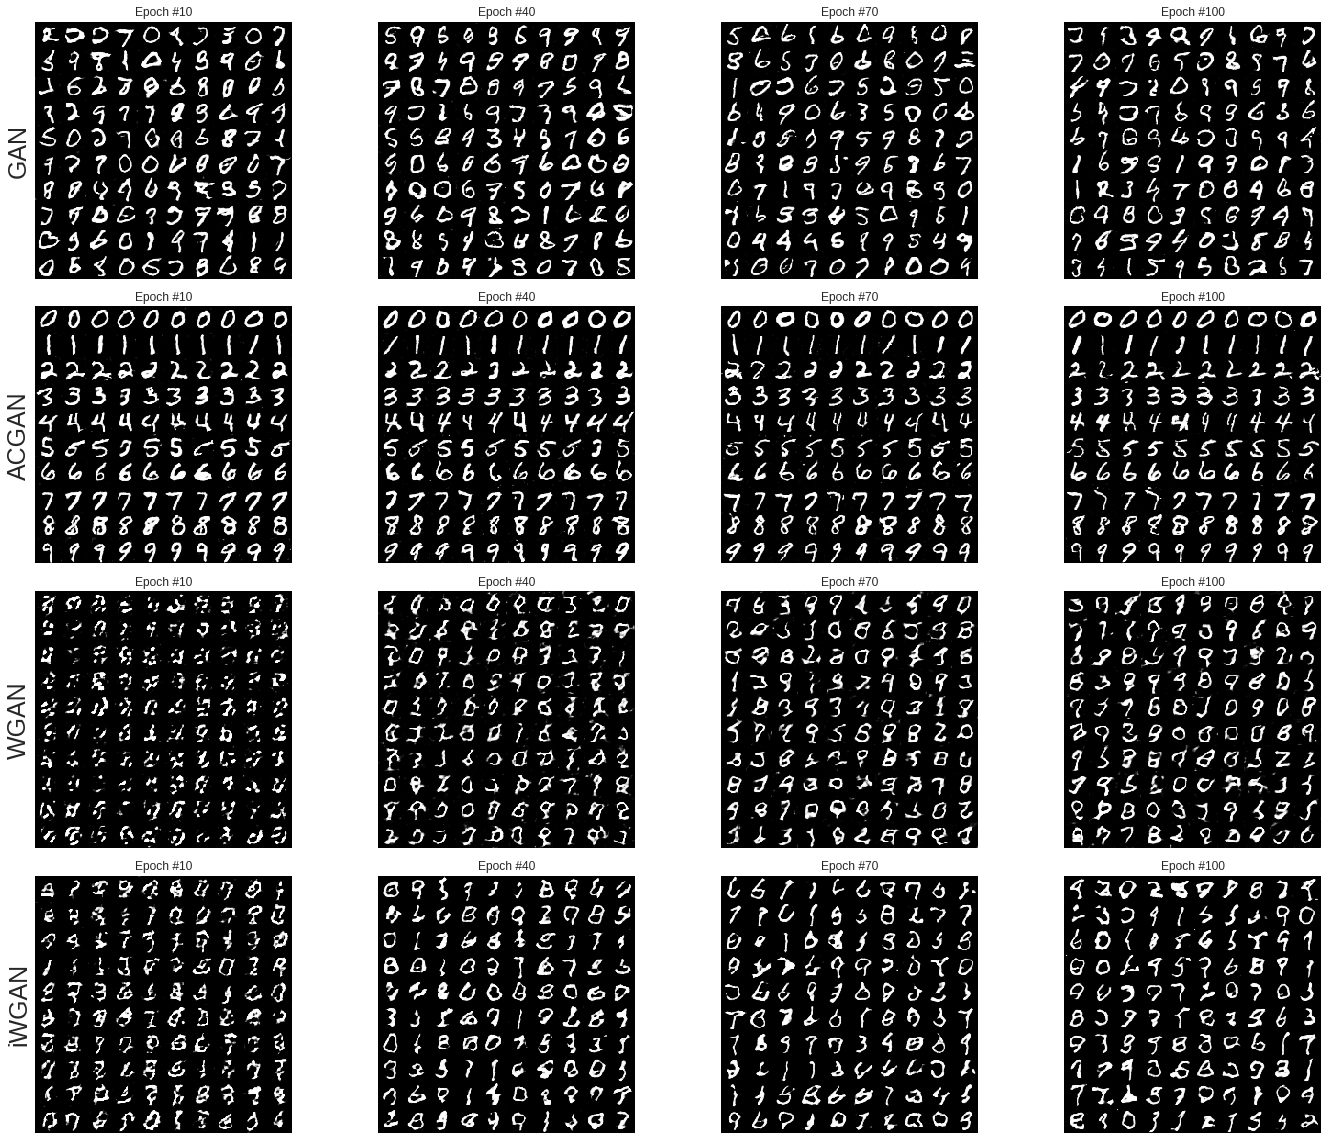

In [15]:
headers = ['GAN', 'ACGAN', 'WGAN', 'iWGAN']
num_rows = len(headers)
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, 4 * num_rows))

for r, h in enumerate(headers):
    samples = mnist_samples[h][1:]
    for col, ax in enumerate(axes[r]):
        display_digits(ax, samples[col][1], 'Epoch #{}'.format(samples[col][0]))
    axes[r][0].set_ylabel(h, rotation=90, size=25)


fig.tight_layout()
plt.show(fig)

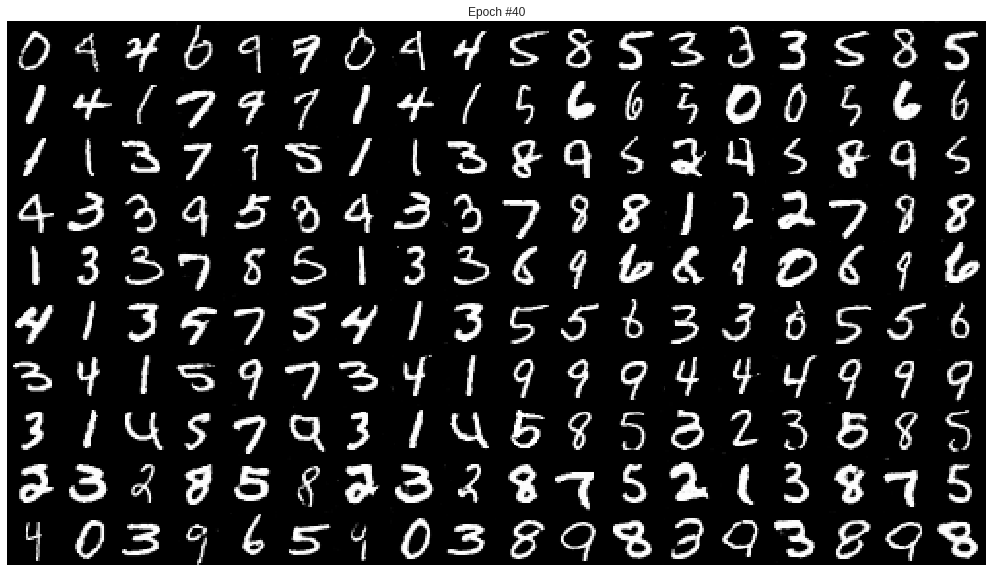

INFO:tensorflow:Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoints/MNIST/DiscoGAN/DiscoGAN-34360
INFO:tensorflow:Success to read DiscoGAN-34360


In [16]:
from deep_networks.models import discogan
from deep_networks.models.gan import ConvDiscriminator

def sample_DiscoGAN(samples, num_batches, data_x_, data_y_):
    def sample(gan, step):
        epoch = step // num_batches

        data_x, gen_y, recon_x = gan.sample_y(x=data_x_.eval())
        data_y, gen_x, recon_y = gan.sample_x(y=data_y_.eval())

        cols = [
            data_x, gen_y, recon_x,
            data_y, gen_x, recon_y
        ]
        cols = [denorm(data) for data in cols]
        samples.append((epoch, cols))
        
        images = []
        
        for data in cols:
            images.append(data[:30])
        images = np.vstack(images)

        clear_output()
        plot_digits(images, 'Epoch #{}'.format(epoch), num_cols=18)
    
    return sample

with tf.Graph().as_default():
    with tf.Session() as sess:
        samples = []
        sample_step = [1] + [i * mnist_num_batches for i in (1, 10, 40)]

        mnist_data, labels = get_mnist_data()
        
        data_x, _, data_y, _ = split_mnist_data(mnist_data, labels)

        gan = discogan.DiscoGAN(sess,
                       data_x,
                       data_y,
                       num_examples=mnist_num_examples,
                       x_output_shape=mnist_output_shape,
                       y_output_shape=mnist_output_shape,
                       batch_size=mnist_batch_size,
                       generator_cls=discogan.ConvResizeConvGenerator,
                       discriminator_cls=ConvDiscriminator,
                       g_dim=32,
                       d_dim=32)
        
        gan._trange = tnrange
        gan.init_saver(tf.train.Saver(max_to_keep=None))

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        sample_fn = sample_DiscoGAN(samples, mnist_num_batches, data_x, data_y)
        resume_step = sample_and_load(gan, sample_step, mnist_checkpoint_dir, sample_fn)

        gan.train(num_epochs=40,
                  log_dir=mnist_log_dir,
                  checkpoint_dir=mnist_checkpoint_dir,
                  resume_step=resume_step,
                  sample_step=sample_step,
                  save_step=None,
                  sample_fn=save_and_sample(mnist_checkpoint_dir, sample_fn))
        
        coord.request_stop()
        coord.join(threads)
        
        mnist_samples['DiscoGAN'] = samples